# Initial EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("data/transactions_dataset.csv", sep=";")
df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


In [4]:
df.describe()

,product_id,client_id,sales_net,quantity,branch_id
count,6.331932e+07,6.331932e+07,6.331932e+07,6.331932e+07,6.331932e+07
mean,1.632321e+06,1.139833e+06,1.479416e+02,9.215658e+01,5.466714e+03
std,9.184524e+05,6.552536e+05,8.646548e+02,8.674801e+02,3.175258e+03
min,1.500000e+01,6.000000e+00,-1.738817e+06,3.000000e+00,2.000000e+01
25%,8.517370e+05,5.658470e+05,1.414653e+01,3.000000e+00,2.907000e+03
50%,1.621731e+06,1.152241e+06,4.424280e+01,5.000000e+00,5.226000e+03
75%,2.434262e+06,1.706977e+06,1.314680e+02,2.100000e+01,8.361000e+03
max,3.238833e+06,2.274517e+06,1.740456e+06,1.980010e+05,1.105700e+04


We have negative sales, what does that mean => we may want to set those to 0.

In [5]:
# Replace negative sales_net values with 0
df.loc[df['sales_net'] < 0, 'sales_net'] = 0

In [6]:
# Let us look at what date range the data covers
df["date_order"] = pd.to_datetime(df["date_order"])
print(f"The first order was made on {df["date_order"].min().strftime("%B %d, %Y")}")
print(f"The last order was made on {df["date_order"].max().strftime("%B %d, %Y")}")

The first order was made on September 22, 2017
The last order was made on September 22, 2019


In [7]:
# Let us print the different order channels:
for i in df["order_channel"].unique():
    print(f"- {i}")

- online
- at the store
- by phone
- during the visit of a sales rep
- other


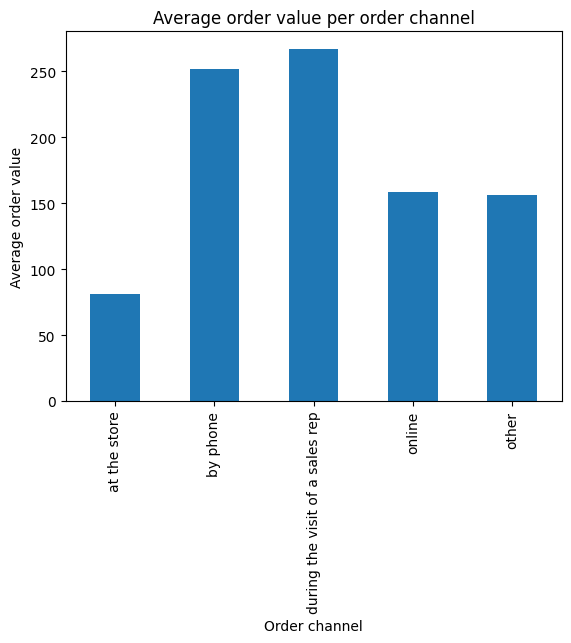

In [8]:
# Let us plot the average order value per order channel
df.groupby("order_channel")["sales_net"].mean().plot.bar()
plt.title("Average order value per order channel")
plt.ylabel("Average order value")
plt.xlabel("Order channel")
plt.show()

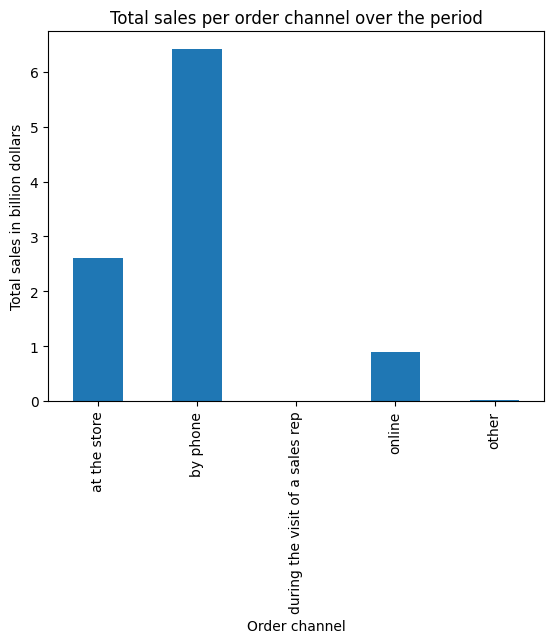

In [9]:
# Let us plot the total sales for each order channel
order_sales_by_channel = df.groupby("order_channel")["sales_net"].sum() / 1e9
order_sales_by_channel.plot.bar()
plt.title("Total sales per order channel over the period")
plt.ylabel("Total sales in billion dollars")
plt.xlabel("Order channel")
plt.show()

On average, a client made 371.18 orders over the period
The median number of orders per client is 50.0


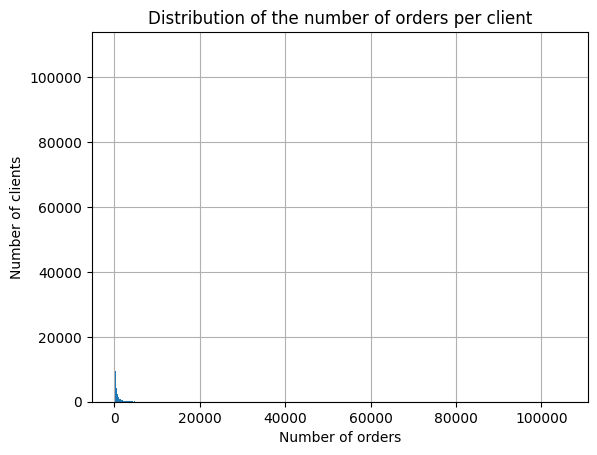

In [10]:
print(f"On average, a client made {df.shape[0] / df["client_id"].nunique():.2f} orders over the period")
# Let us compute the median number of orders per client
print(f"The median number of orders per client is {df.groupby("client_id").size().median()}")
# Let us now plot the distribution of the number of orders per client
df.groupby("client_id").size().hist(bins=1000)
plt.title("Distribution of the number of orders per client")
plt.ylabel("Number of clients")
plt.xlabel("Number of orders")
plt.show()

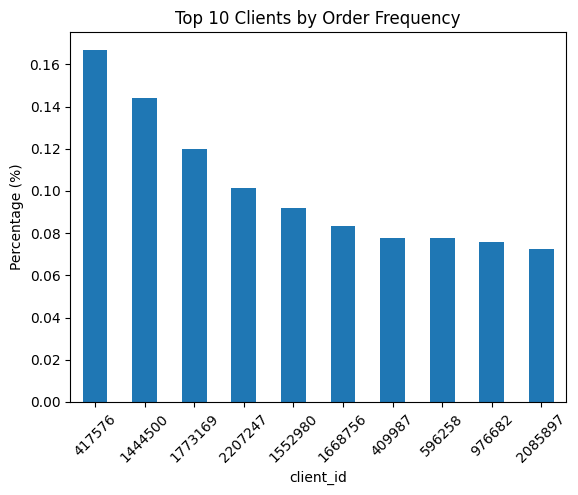

In [11]:
# Let us plot the biggest clients in terms of % of orders
client_counts = df["client_id"].value_counts(normalize=True).head(10) * 100

ax = client_counts.plot.bar()

# Format y-axis to show percentage
ax.set_ylabel("Percentage (%)")
ax.set_title("Top 10 Clients by Order Frequency")
plt.xticks(rotation=45)  # Rotate x labels for readability
plt.show()

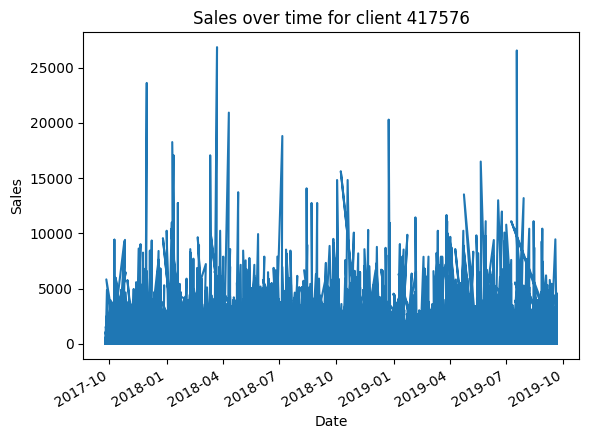

In [12]:
# Let us plot the orders over time for client 417576
client_417576 = df[df["client_id"] == 417576]
client_417576.set_index("date_order")["sales_net"].plot()   
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales over time for client 417576")
plt.show()

# Data preprocessing

Our objective here is to predict churn for all recurring clients that we have. We want to predict churn and prevent it before it is too late.

1. From the data that we have, we will create new features that give us more information on the client's orders 
1. Using the data at hand and these new features, we will make an assumption on who are the churned clients.
3. Based on this labeled data, we will train a classifier (here an XGBoost Classifier) and use the outputted probabilities to prevent clients from churning when their churning probability exceeds a predefined threshold.
4. Then, depending on the client size in terms of sales, we would send them an email or call them to engage and make sure they remain our client.

Here are the assumption that we made when building the training dataset and our model. We want to predict a churn probability for each client based on their order habits and their current order behaviour. For this, we included the following features:
- tenure: the number of days between first order and last order
- recency: the number days between today and the last order
- average_interval_between_last_3_orders: the average number of days between the last 3 orders
- average_order_interval: the average number of days between each order
- order_standard_deviation: the standard deviation of these intervals

We then defined a churn_threshold_date based on the average_order_interval and the order_standard_deviation.
The formula for churn_threshold_date is given by: `last_order_date + churn_threshold_multiplier * (average_order_interval + 2 * order_standard_deviation) + 2`
- We took the last_order_date
- We added the average_order_interval + 2 times the order_standard_deviation. We chose this because a threshold of mean + 2× std captures 95% of normal behavior when assuming a normal distribution of order intervals (which we can assume using the central limit theorem)
- We then multiplied this by a churn_threshold_multiplier = 2.5. This is arbitrary and must be adjusted using industry / business knowledge of the actual churn rate. Given industry comparables, we made the assumption that labelling 20% of clients as churned in the training set was reasonable.
- Finally, we added 2 to take weekends into consideration: clients do not order on weekends, or at least not most of them - so if they order very frequently but not during weekends, we do not want to label them as churning.

In [13]:

def nth_last_order(dates, n=1):
    """
    This function returns the nth last order date in a pandas Series of dates.
    We will use it to compute the average interval between the last 3 orders.
    """
    sorted_dates = dates.sort_values()
    if len(sorted_dates) < n:
        return np.nan
    return sorted_dates.iloc[-n]

# We define the last date of the data
end_of_df_date = df["date_order"].max()

# We create an aggregated dataframe with the columns that we will use in the training
agg_df = (
    df
    .groupby('client_id')
    .agg(
        number_of_orders= ("product_id","count"),
        total_sales = ("sales_net", "sum"),
        first_order_date= ("date_order", "min"),
        last_order_date=('date_order', lambda x: nth_last_order(x, 1)),
        n_1_order_date=('date_order', lambda x: nth_last_order(x, 2)),
        n_2_order_date=('date_order', lambda x: nth_last_order(x, 3))
    )
    .reset_index()
)


agg_df["first_order_date"] = pd.to_datetime(agg_df["first_order_date"])
agg_df["last_order_date"] = pd.to_datetime(agg_df["last_order_date"])
agg_df["n_1_order_date"] = pd.to_datetime(agg_df["n_1_order_date"]) 
agg_df["n_2_order_date"] = pd.to_datetime(agg_df["n_2_order_date"])

# We compute the tenure, recency, average interval between last 3 orders and average order interval
agg_df["tenure"] = (agg_df["last_order_date"] - agg_df["first_order_date"]).dt.days
agg_df["recency"] = (end_of_df_date - agg_df["last_order_date"]).dt.days
agg_df["average_interval_between_last_3_orders"] = (((agg_df["n_1_order_date"] - agg_df["n_2_order_date"]).dt.total_seconds() / 86400) + ((agg_df["last_order_date"] - agg_df["n_1_order_date"]).dt.total_seconds() / 86400))/2
agg_df["average_order_interval"]= ((agg_df["last_order_date"] - agg_df["first_order_date"]) / agg_df["number_of_orders"]).dt.total_seconds() / 86400

# We compute the standard deviation of the order interval
df_int = df.copy()
df_int["date_order"] = pd.to_datetime(df_int["date_order"])
df_int = df_int.sort_values(by=["client_id", "date_order"])
df_int["order_interval"] = df_int.groupby("client_id")["date_order"].diff().dt.total_seconds() / 86400 
order_std = df_int.groupby("client_id")["order_interval"].std().reset_index()
order_std.columns = ["client_id", "order_standard_deviation"]
agg_df = agg_df.merge(order_std, on="client_id", how="left")


# churn_threshold_multiplier must be revised using industry knowledge i.e. what are the business numbers for churn
churn_threshold_multiplier = 2.5
# the threshold date is the last order date + churn_threshold_multiplier * (the average order interval + 2 times the standard deviation) + 2 days to take weekends into account
agg_df["churn_threshold_date"] = (agg_df["last_order_date"] + pd.to_timedelta(churn_threshold_multiplier*(agg_df["average_order_interval"] + 2 * agg_df["order_standard_deviation"])+2,unit="D")).dt.floor("D")
agg_df["churned"] = agg_df["churn_threshold_date"] < end_of_df_date

# Fill NaN values with 0 (for clients with only one order)
agg_df["order_standard_deviation"].fillna(0, inplace=True)
agg_df.head()

,client_id,number_of_orders,total_sales,first_order_date,last_order_date,n_1_order_date,n_2_order_date,tenure,recency,average_interval_between_last_3_orders,average_order_interval,order_standard_deviation,churn_threshold_date,churned
0,6,40,5.882233e+03,2017-10-27,2019-08-13,2019-07-31,2019-07-31,655,40,6.5,16.375000,44.097487,2020-05-02,False
1,7,15,1.190777e+03,2018-07-16,2018-12-24,2018-12-24,2018-12-24,161,272,0.0,10.733333,43.029060,2019-08-24,True
2,14,12762,3.154930e+06,2017-09-25,2019-09-20,2019-09-20,2019-09-20,725,2,0.0,0.056809,0.335680,2019-09-23,False
3,18,2224,2.456277e+05,2017-09-26,2019-09-12,2019-09-12,2019-09-12,716,10,0.0,0.321942,1.252070,2019-09-21,True
4,25,4,3.745861e+02,2018-10-10,2018-10-10,2018-10-10,2018-10-10,0,347,0.0,0.000000,0.000000,2018-10-12,True


We then decided to train on *recurring clients* as new or short-term clients can be considered as outliers and could lead to overfitting. For this reason we only kept:
- clients with a tenure > 60 days
- clients with more than 10 orders in total

In [24]:
# Let us just keep the clients that have been ordering over more than 2 months
print(f"Clients before filtering: {agg_df.shape[0]}")
agg_df = agg_df[agg_df["tenure"]>60]
print(f"Client after filtering: {agg_df.shape[0]}")

Clients before filtering: 123529
Client after filtering: 123529


In [25]:
# Let us keep clients who made more than 10 orders in total
print(f"Clients before filtering: {agg_df.shape[0]}")
agg_df = agg_df[agg_df["number_of_orders"] > 10]
print(f"Client after filtering: {agg_df.shape[0]}")

Clients before filtering: 123529
Client after filtering: 123529


In [26]:
# Churn of clients from before Sep 2018 
agg_df["churned"][agg_df["first_order_date"]<pd.to_datetime("2018-09-22")].value_counts(normalize=True)* 100

churned
False    79.194938
True     20.805062
Name: proportion, dtype: float64

In [27]:
# Churn of clients from after Sep 2018 
agg_df["churned"][agg_df["first_order_date"]>=pd.to_datetime("2018-09-22")].value_counts(normalize=True)* 100

churned
False    81.006264
True     18.993736
Name: proportion, dtype: float64

The churn rate seem reasonable in our training set. Again, using industry knowledge, the client could help us fine-tune the churn_threshold_multiplier.

# Model training

In [28]:
# Let us now select only the columns we want to keep for training
final_df = agg_df[[
    "client_id",
    "number_of_orders",
    "total_sales",
    "average_order_interval",
    "average_interval_between_last_3_orders",
    "order_standard_deviation",
    "tenure",
    "recency",
    "churned"]]

In [29]:
# We went for an XGBoost classifier 
X = final_df.drop(columns=["client_id", "churned"])
y = final_df["churned"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)
X_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, X_pred)

print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 99.71%


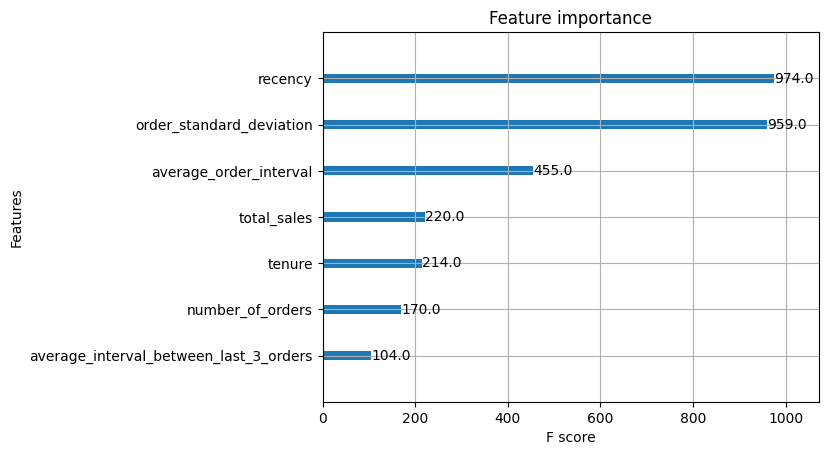

In [31]:
plot_importance(model)
plt.show()

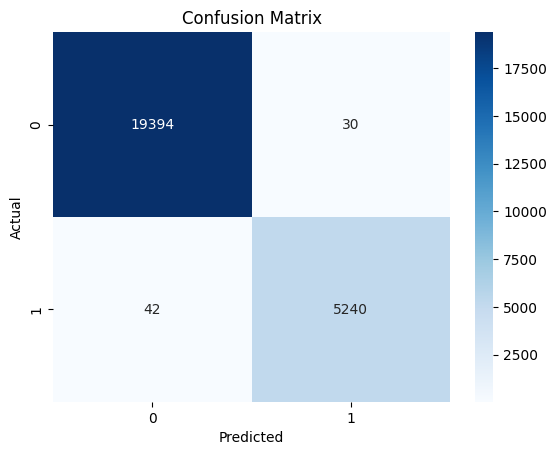

In [32]:
conf_matrix = confusion_matrix(y_test, X_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss"
)
model.fit(X_train, y_train)

X_pred_probas = np.round(model.predict_proba(X_test),2)
X_pred_probas

array([[0.01, 0.99],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ]], shape=(24706, 2), dtype=float32)

We can now use this model to predict churn for each client on a daily basis. Given the probability outputted, we could prevent the client from churning by reaching out to them.